# Available digest modules:
cif2png_utils, tif2png_utils, montage2png_utils, tif2tensor_utils

In [2]:
import tif2tensor_utils

Using TensorFlow backend.


In [3]:
import keras
import numpy
import matplotlib.pyplot
import os.path
import pandas
import seaborn
import sklearn.metrics
import keras.applications
import keras.preprocessing.image
import tensorflow

# User's settings

In [16]:
directory = "/home/minh-doan/Cell_cycle/temp_processed_Juan"

data = {
    "G1": "/home/minh-doan/Cell_cycle/Step2_input_single_tifs/G1/",
    "S_phase": "/home/minh-doan/Cell_cycle/Step2_input_single_tifs/S_phase/",
    "G2": "/home/minh-doan/Cell_cycle/Step2_input_single_tifs/G2/",
    "Prophase": "/home/minh-doan/Cell_cycle/Step2_input_single_tifs/Prophase/",
    "Anaphase": "/home/minh-doan/Cell_cycle/Step2_input_single_tifs/Anaphase/",
    "Metaphase": "/home/minh-doan/Cell_cycle/Step2_input_single_tifs/Metaphase/",
    "Telophase": "/home/minh-doan/Cell_cycle/Step2_input_single_tifs/Telophase/"
}

channels = [3]

image_size = 40

split = {
    "Training" : 0.8,
    "Validation" : 0.1,
    "Testing" : 0.1
}

classes = len(data.keys())

# If using tensor:

In [ ]:
# class_weights = tif2tensor_utils.parse(directory, data, channels, image_size, split)

# If using PNG:

In [ ]:
tif2png_utils.parse(directory, data, channels, image_size)

tif2png_utils.split(directory, data.keys(), split, image_size)

class_weights = tif2png_utils.class_weights("/home/minh-doan/Cell_cycle/temp_processed/Training/", data)

# Adapt LeNet-5 convolutional neural network by Yann LeCun, et al.

In [ ]:
shape = (image_size, image_size, 1)

x = keras.layers.Input(shape)

In [ ]:
options = {"activation": "relu", "kernel_size": (3, 3)}

y = keras.layers.Conv2D(32, **options)(x)
y = keras.layers.Conv2D(64, **options)(y)

y = keras.layers.MaxPooling2D()(y)

y = keras.layers.Dropout(0.5)(y)

y = keras.layers.Flatten()(y)

y = keras.layers.Dense(128, activation="relu")(y)

y = keras.layers.Dropout(0.5)(y)

y = keras.layers.Dense(classes)(y)

y = keras.layers.Activation("softmax")(y)

In [ ]:
model = keras.models.Model(x, y)

In [ ]:
loss = keras.losses.categorical_crossentropy

optimizer = keras.optimizers.Adam(0.0001)

model.compile(
    loss=loss, 
    metrics=[
        "accuracy"
    ],
    optimizer=optimizer
)

In [ ]:
training_x = numpy.load(os.path.join(directory, "training_x.npy"))

training_y = numpy.load(os.path.join(directory, "training_y.npy"))

In [ ]:
training_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range = 180, horizontal_flip = True, vertical_flip = True)

training_generator = training_generator.flow(
    x = training_x,
    y = training_y,
    batch_size=32
)

In [ ]:
validation_x = numpy.load(os.path.join(directory, "validation_x.npy"))

validation_y = numpy.load(os.path.join(directory, "validation_y.npy"))

In [ ]:
validation_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range = 180, horizontal_flip = True, vertical_flip = True)

validation_generator = validation_generator.flow(
    x = validation_x,
    y = validation_y,
    batch_size=32
)

In [ ]:
csv_logger = keras.callbacks.CSVLogger(os.path.join(directory, 'training.csv') )

early_stopping = keras.callbacks.EarlyStopping(patience=64)

# checkpoint
filepath = os.path.join(directory, "weights.best.hdf5")
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
configuration = tensorflow.ConfigProto()

configuration.gpu_options.allow_growth = True

session = tensorflow.Session(config=configuration)

keras.backend.set_session(session)

In [ ]:
with tensorflow.device("/gpu:0"):
    model.fit_generator(
        callbacks=[
            checkpoint,
            csv_logger
        ],
        epochs=8,
        class_weight = class_weights,
        generator=training_generator,
        max_q_size=256,
        steps_per_epoch=2000,
        validation_data=validation_generator,
        validation_steps=2000
    )

# Adapt pretrained VGG19 network

In [6]:
# Change here the number of channesl: for VGG19 expecting (224,224,3) with 3 channels, for homemade model it's (image_size, image_size, 1)
shape = (224, 224, 3)

In [7]:
VGG19 = keras.applications.VGG19(include_top = False, classes = classes)

In [8]:
for layer in VGG19.layers:
    layer.trainable = False
    
x = VGG19.output
x = keras.layers.GlobalAveragePooling2D()(x)

In [ ]:
# For classification:
# x = keras.layers.Dense(4096, activation='relu')(x)
# x = keras.layers.BatchNormalization()(x)

# For Tensorboard embedding:
intermediate_layer = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.BatchNormalization()(intermediate_layer)
x = keras.layers.Dropout(rate=0.5)(x)

predictions = keras.layers.Dense(classes, activation='softmax')(x)

# this is the model we will train
model = keras.models.Model(input=VGG19.input, output=predictions)

In [ ]:
# model.summary()

In [10]:
optimizer = keras.optimizers.Adam(lr = 0.0001)

loss = keras.losses.categorical_crossentropy

metrics = [
    keras.metrics.categorical_accuracy
]

model.compile(optimizer, loss, metrics)

In [11]:
training_x = numpy.load(os.path.join(directory, "training_x.npy"))

training_y = numpy.load(os.path.join(directory, "training_y.npy"))

# Because VGG19 need 3 channels RGB not single-channel grayscale:
training_xx = numpy.concatenate((training_x,training_x,training_x), axis=3)

In [12]:
training_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range = 180, horizontal_flip = True, vertical_flip = True)

training_generator = training_generator.flow(
    x = training_xx,
    y = training_y,
    batch_size=32
)

In [13]:
validation_x = numpy.load(os.path.join(directory, "validation_x.npy"))

validation_y = numpy.load(os.path.join(directory, "validation_y.npy"))

# Because VGG19 need 3 channels RGB not single-channel grayscale:
validation_xx = numpy.concatenate((validation_x,validation_x,validation_x), axis=3)

In [14]:
validation_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range = 180, horizontal_flip = True, vertical_flip = True)

validation_generator = validation_generator.flow(
    x = validation_xx,
    y = validation_y,
    batch_size=32
)

In [19]:
# csv_logger = keras.callbacks.CSVLogger("training.csv") # be careful not to overwrite training.csv from above LeNet training.

early_stopping = keras.callbacks.EarlyStopping(patience=64)

# checkpoint
filepath = os.path.join(directory, "weights.best.hdf5")
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
with tensorflow.device("/gpu:0"):
    model.fit_generator(
        callbacks=[
            callbacks_list
            #csv_logger
        ],
        epochs=8,
        generator=training_generator,
        max_q_size=256,
        steps_per_epoch=2000,
        validation_data=validation_generator,
        validation_steps=2000
    )

In [22]:
testing_x = numpy.load(os.path.join(directory, "testing_x.npy"))

testing_y = numpy.load(os.path.join(directory, "testing_y.npy"))

# Because VGG19 need 3 channels RGB not single-channel grayscale:
testing_xx = numpy.concatenate((testing_x,testing_x,testing_x), axis=3)

In [23]:
test_generator = keras.preprocessing.image.ImageDataGenerator(rotation_range = 180, horizontal_flip = True, vertical_flip = True)

test_generator = test_generator.flow(
    x = testing_xx, # for 3-channel RGB
    y = testing_y,
    batch_size=32
)

model.evaluate_generator(
    generator=test_generator, 
    steps=256
)

[0.61660165661826738, 0.74132877417931509]

# Generate Graph for visualization in Tensorboard

In [ ]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./', histogram_freq=0, write_graph=True, write_images=True)

options = {
    "batch_size": 1,
    "class_weight": class_weights,
    "callbacks": [
        tbCallBack
    ],
    "epochs": 1,
    "verbose": 0,
    "x": test_xx,
    "y": test_y    
}

%time model.fit(**options)

# Generate embeddings for visualization in Tensorboard

In [26]:
# Converting one-hot labels into serial numbers [0,1,2,3...]
def save_metadata(file):
    with open(file, 'w') as f:
        for i in range(testing_y.shape[0]):
            c = numpy.nonzero(testing_y[::1])[1:][0][i]
            f.write('{}\n'.format(c))
            
save_metadata('./metadata.tsv')

In [ ]:
from tensorflow.contrib.tensorboard.plugins import projector

# Create randomly initialized embedding weights which will be trained.
N = testing_y.shape[0] # Number of items
print(N)
D = 4096 # Dimensionality of the embedding Dense layer

intermediate_values = intermediate_layer.eval(feed_dict = {VGG19.input : testing_xx}, session = keras.backend.get_session())
print(intermediate_values.shape)
print(type(intermediate_values))

In [ ]:
embedding_var = tensorflow.Variable(intermediate_values)

# file names
ROOT_DIR = './' # Pay attention here ! If specify this path as absolute path, the resulted files have to be read with the same folder path
OUTPUT_MODEL_FILE_NAME = os.path.join(ROOT_DIR,'tf.ckpt')

# keras.backend.get_session()
embedSess = tensorflow.Session()

# save variable in session
embedSess.run(embedding_var.initializer)
# embedSess.run(tensorflow.global_variables_initializer())

# save session (only used variable) to file
saver = tensorflow.train.Saver([embedding_var])
saver.save(embedSess, OUTPUT_MODEL_FILE_NAME)

summary_writer = tensorflow.summary.FileWriter(ROOT_DIR)

config = tensorflow.contrib.tensorboard.plugins.projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name
embedding.metadata_path = '/Users/minhdoan/Desktop/1_copy/metadata.tsv' # Shame on GOOGLE, while absolute path is NOT good otherwise, this metadata HAS TO have absolute path to function
tensorflow.contrib.tensorboard.plugins.projector.visualize_embeddings(summary_writer, config)

# Categorical accuracy and loss

In [ ]:
metrics = pandas.read_csv(os.path.join(directory, 'training.csv') )

In [ ]:
print(metrics)

In [ ]:
%matplotlib inline

In [ ]:
matplotlib.pyplot.plot(metrics["acc"])
matplotlib.pyplot.plot(metrics["val_acc"])

In [ ]:
matplotlib.pyplot.plot(metrics["loss"])
matplotlib.pyplot.plot(metrics["val_loss"])

# Confusion matrix

In [30]:
predicted = model.predict(
    batch_size=50,
#     x=testing_x
    x=testing_xx # for 3-channel RGB
)

predicted = numpy.argmax(predicted, -1)

In [31]:
expected = numpy.argmax(testing_y[:, :], -1)

In [33]:
%matplotlib inline

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


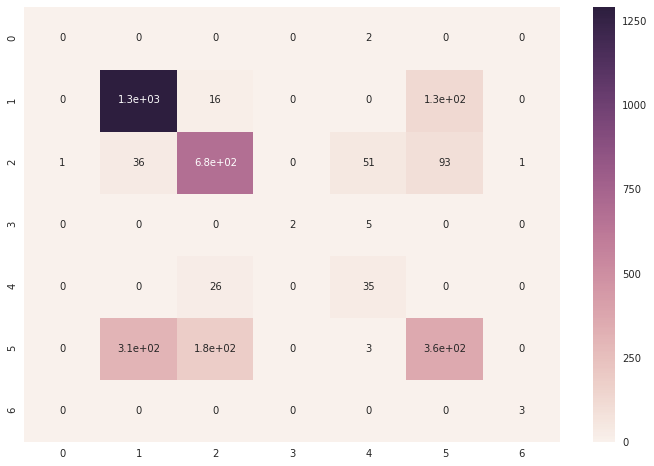

In [34]:
confusion = sklearn.metrics.confusion_matrix(expected, predicted)

confusion = pandas.DataFrame(confusion)

matplotlib.pyplot.figure(figsize=(12, 8))

seaborn.heatmap(confusion, annot=True)

In [ ]:
session.close()